# Previous Learning

In [ ]:

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [ ]:

# Step 2: Build pipeline

pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', Ridge())
])


In [ ]:

# Step 3: Define hyperparameter grid
param_grid = {
    'model__alpha': [0.01, 0.1, 1, 10, 100]
}

In [ ]:

def adj_r2(estimator, X, y_true):
  n, p = X.shape
  pred = estimator.predict(X)
  return 1 - ((1 - r2_score(y_true, pred)) * (n - 1))/(n-p-1)

In [ ]:
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2',
    "adj R2": adj_r2
}


In [ ]:
# Step 4: GridSearchCV
grid = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring=scoring,
    refit='rmse', # Specify which metric to use for refitting the best estimator - “Refit the model using the hyperparameters that gave the best RMSE.”
    n_jobs=-1
)


In [ ]:

# Step 5: Fit
grid.fit(X, y)


In [ ]:
grid.best_params_

In [ ]:

grid.cv_results_

In [ ]:

# Step 6: Result
print("Best RMSE:", -grid.best_score_)
print("Best alpha:", grid.best_params_)


In [ ]:
# Access All The Result
results = pd.DataFrame(grid.cv_results_)
results.head()

In [ ]:

results = results[['param_model__alpha', 'mean_test_rmse', 'mean_test_mae', 'mean_test_mse', 'mean_test_r2', 'mean_test_adj R2']]

# Rename columns for better readability
results.rename(columns={
    'param_model__alpha': 'Alpha',
    'mean_test_rmse': 'Mean RMSE',
    'mean_test_mae': 'Mean MAE',
    'mean_test_mse': 'Mean MSE',
    'mean_test_r2': 'Mean R2',
    'mean_test_adj R2': 'Mean Adjusted R2'
}, inplace=True)

display(results.sort_values(by='Mean RMSE'))

**1️⃣ First: Big picture of what this GridSearchCV is doing**

You are saying:

> “For each hyperparameter combination, evaluate my pipeline using multiple metrics across 5-fold CV,
then choose the best hyperparameters using RMSE,
then retrain the final model using those hyperparameters.”

That’s it. Everything below supports this intent.

---

**2️⃣ scoring dictionary — why multiple metrics?**


```
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2',
    "adj R2": adj_r2
}

```



**What this means conceptually**

You are telling sklearn:

> “For each CV fold, evaluate my model in multiple ways, not just one.”

This is evaluation, not training.

---

**Why sklearn uses “negative” errors 🤦‍♂️**

Sklearn assumes:

> Higher score = better

But error metrics are:

```
RMSE ↓

MAE ↓

MSE ↓
```

So sklearn flips the sign:

```
Lower RMSE → Higher (less negative) score
```

Example:
```
RMSE = 5   → score = -5  (better)
RMSE = 10  → score = -10 (worse)
```

⚠️ This is annoying but important.

---

**Each entry explained**

🔹 'rmse': 'neg_root_mean_squared_error'

- Square root of average squared error

- Penalizes large errors

- Same unit as target

- Common choice for refit

🔹 'mae': 'neg_mean_absolute_error'

- Linear penalty

- More robust to outliers

- Easier to interpret

🔹 'mse': 'neg_mean_squared_error'

- Strongly penalizes outliers

- Rarely used alone (hard to interpret)

🔹 'r2': 'r2'

- Variance explained

- Scale-free

- Can be misleading with weak models

🔹 "adj R2": adj_r2

- Custom scoring function

- Corrects R² for number of features

- Useful when feature count varies

📌 Important:

- Custom metrics must follow sklearn’s scoring API

- They are called after predictions, not during training

---


3️⃣ What happens during CV with multiple metrics?

For each fold, sklearn computes:
```
rmse
mae
mse
r2
adj_r2
```

Then for each hyperparameter combo, it stores:
```
mean_test_rmse
mean_test_mae
mean_test_mse
mean_test_r2
mean_test_adj_R2
```

You can inspect them via:
```
grid.cv_results_
```

---


4️⃣ **cv=5** — but you already know this part 😉

- Split training data into 5 folds

- Rotate validation fold

Each fold:

- Pipeline fit on fold-train

- Evaluated on fold-val

---

5️⃣ **refit='rmse' — THIS is the most important line**

```
refit='rmse'
```

This answers the question:

> “Which metric should decide the final hyperparameters?”

Even though you compute many metrics, sklearn needs ONE to:

1. Rank hyperparameter combinations

2. Select the best one

3. Retrain the final model

So here:
👉 Lowest RMSE (i.e., highest neg RMSE) wins.

---

**What happens internally**

After CV finishes:

1. Look at mean_test_rmse

2. Find hyperparameters with best value

3. Retrain pipeline on FULL training data

4. Store result in best_estimator_

If **refit=False**:

- No final model is trained

- You only get CV results

---

6️⃣ **n_jobs=-1**

```
n_jobs=-1
```

- Uses all CPU cores

Parallelizes:

- CV folds

- Hyperparameter combinations

⚠️ Watch memory usage with large pipelines.

---

7️⃣ **How all of this fits together (visual)**

```
Pipeline
   ↓
GridSearchCV
   ├── Hyperparam set 1
   │     ├── Fold 1 → rmse, mae, r2...
   │     ├── Fold 2
   │     └── Fold 5
   ├── Hyperparam set 2
   └── Hyperparam set N
        ↓
Aggregate metrics
        ↓
Choose best by RMSE
        ↓
Refit on full training data
        ↓
best_estimator_
```

---

8️⃣ **Common mistakes (interview traps)**

❌ Forgetting refit when using multiple metrics

❌ Thinking all metrics affect training

❌ Misinterpreting negative scores

❌ Using test set metrics in scoring

| Case                   | Train Performance | Test Performance      | Train vs Test Gap | Bias     | Variance | What’s Happening                      | Typical Fix                             |
| ---------------------- | ----------------- | --------------------- | ----------------- | -------- | -------- | ------------------------------------- | --------------------------------------- |
| **Underfitting**       | ❌ Low             | ❌ Low                 | Small             | **High** | Low      | Model too simple, can’t learn pattern | Increase model complexity, add features |
| **Good Fit (Ideal)**   | ✅ High            | ✅ High                | Small             | Low      | Low      | Model learns signal, generalizes well | Stop here 😄                            |
| **Mild Overfitting**   | ✅ High            | ⚠️ Medium             | Moderate          | Low      | Medium   | Model learns noise a bit              | Regularization, more data               |
| **Severe Overfitting** | ✅ Very High       | ❌ Very Low / Negative | Large             | Low      | **High** | Model memorizes training data         | Strong regularization, simplify model   |


# Bias Varience

**🧠 Layer 1: Forget words. Think in questions**

Every ML model answers two questions:

1. **Can I learn the training data?**

2. **Can I generalize to new data?**

That’s it. Everything else is naming.

---

**🧠 Layer 2: Train vs Test = the ONLY signal you need**

| Train score | Test score | Meaning (plain English) |
| ----------- | ---------- | ----------------------- |
| ❌ Low       | ❌ Low      | Model is **too dumb**   |
| ✅ High      | ❌ Low      | Model is **too clever** |
| ✅ High      | ✅ High     | Model is **just right** |


Now we attach names 👇

---

**🧠 Layer 3: Attach the names (this is where confusion happens)**

1️⃣ Underfitting (Too Simple)

Symptom


```
Train ❌ low
Test  ❌ low
```





Meaning

- Model cannot learn the pattern

- Even training data looks confusing to it

Bias–Variance

- High Bias (wrong assumptions)

- Low Variance (stable but wrong)

🧠 Think:

> “My model is biased toward being simple.”

---

**2️⃣ Overfitting (Too Complex)**

Symptom

```
Train ✅ high
Test  ❌ low
```

Meaning

- Model memorizes training data

- Fails on new data

Bias–Variance

- Low Bias (can fit anything)

- High Variance (changes wildly)

🧠 Think:

> “My model reacts too much to small data changes.”

---

**3️⃣ Good Fit (Balanced)**

Symptom
```
Train ✅ high
Test  ✅ high
```

Meaning

- Learned signal

- Ignores noise

Bias–Variance

- Low Bias

- Low Variance

---

**🧠 Layer 4: ONE table to rule them all (save this)**

```
TRAIN  TEST   →  WHAT IT IS     →  BIAS     VARIANCE
----------------------------------------------------
Low    Low    →  Underfitting  →  High     Low
High   Low    →  Overfitting   →  Low      High
High   High   →  Good Fit      →  Low      Low
```

📌 Key rule

> Train ≈ Test does NOT mean good

> Train HIGH and Test HIGH means good

---

**🧠 Why your brain keeps mixing this up**

Because:

- Over/Under fitting → what you SEE (train/test behavior)

- Bias/Variance → WHY it happens (cause)

They are not separate concepts — they are effect vs cause.

---

**🎯 Ultra-simple memory trick**

**Bias = stubbornness**

> “I refuse to bend even when data wants me to.”

→ Underfitting

**Variance = overreacting**

> “Tiny data change? I’ll change everything!”

→ Overfitting

---

**🎓 Interview killer explanation**

“Underfitting happens due to high bias, where the model is too simple to capture the data pattern. Overfitting happens due to high variance, where the model fits noise and fails to generalize.”

# Interpretation



```
R-squared values:

Polynomial degree 1: train score=0.29, test score=0.25
Polynomial degree 2: train score=0.34, test score=0.22
Polynomial degree 3: train score=0.34, test score=0.22
Polynomial degree 6: train score=0.36, test score=0.11
Polynomial degree 10: train score=0.37, test score=-108.76
Polynomial degree 20: train score=0.38, test score=-307071892464.36
```

----

**First: How to read R² (important reminder)**

- R² = 1 → perfect fit

- R² = 0 → same as predicting the mean

- R² < 0 → worse than predicting the mean (this shocks people)

So negative R² is a huge red flag.

---

**Your results (reframed)**

| Polynomial Degree | Train R² | Test R²  |
| ----------------- | -------- | -------- |
| 1                 | 0.29     | 0.25     |
| 2                 | 0.34     | 0.22     |
| 3                 | 0.34     | 0.22     |
| 6                 | 0.36     | 0.11     |
| 10                | 0.37     | -108.76  |
| 20                | 0.38     | -3.07e11 |

---

**Step-by-step interpretation**

🔴 Degree 1 — Underfitting

What you see

- Train low (0.29)

- Test low (0.25)

- Train ≈ Test

Why

- Linear model is too simple

- Cannot capture non-linear patterns

Diagnosis

👉 High bias (underfitting)

---

🟡 Degree 2–3 — Best you can do here

What you see

- Train improves slightly

- Test does NOT improve

- Small generalization gap

Why

- Slightly more flexible model

- But underlying signal may still be weak or noisy

Diagnosis

👉 Best bias–variance tradeoff in this dataset

📌 This is likely your best model, even though performance is modest.

---

🔵 Degree 6 — Beginning of overfitting

What you see

- Train ↑

- Test ↓

- Gap starts widening

Why

- Model starts fitting noise

- More polynomial terms → more variance

Diagnosis

👉 Overfitting starts

---

🔥 Degree 10 — Severe overfitting + numerical instability

What you see

- Train slightly ↑

- Test catastrophically negative

Why (two reasons)

1️⃣ Extreme variance

- High-degree polynomials oscillate wildly

- Small change in x → huge change in y

2️⃣ Numerical explosion

- Polynomial features like x¹⁰

- Feature magnitudes blow up

- Regression coefficients become huge

- Predictions go insane on unseen data

👉 Result: worse than predicting the mean

---

☢️ Degree 20 — Complete model collapse

What you see

- Train barely improves

- Test R² explodes negatively

Why

- Massive multicollinearity

- Floating point instability

- Model is effectively unusable

👉 This is textbook polynomial overfitting

---

**Key insight (VERY important)**

Notice something subtle:

> Training performance barely improves after degree 3

Yet:

- Model complexity skyrockets

- Test performance collapses

This tells us:

👉 The data does not contain a strong higher-order signal

---

What would FIX this?

✅ Regularization

Ridge / Lasso:

`Penalize large coefficients → stabilize high-degree terms`

✅ Feature scaling

Polynomial features must be scaled

✅ Cross-validation

To prevent selecting degree 10 or 20

---

**Interview-ready explanation**

> Low-degree polynomials underfit because they lack expressive power.
As polynomial degree increases, training performance improves slightly, but test performance degrades due to high variance and numerical instability.
Very high-degree polynomials produce extreme coefficients, leading to catastrophic generalization failure, which is reflected in highly negative R² values.

---

**One-line summary per region**

1. Degree 1 → Underfitting

2. Degree 2–3 → Best model

3. Degree 6 → Overfitting begins

4. Degree ≥10 → Severe overfitting + numerical instability



# Cross Validation (CV)

In [8]:
import kagglehub
path = kagglehub.dataset_download("jnikhilsai/cross-val")

100%|██████████| 10.7k/10.7k [00:00<00:00, 10.6MB/s]

Extracting files...


In [9]:
ls {path}

CarPrice_Assignment.csv  Housing.csv


In [37]:
import pandas as pd

file_path = f"{path}/Housing.csv"
print(file_path)


/root/.cache/kagglehub/datasets/jnikhilsai/cross-val/versions/1/Housing.csv


In [38]:
df = pd.read_csv(file_path)
display(df.head())

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [40]:
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [41]:
df.dtypes

,0
price,int64
area,int64
bedrooms,int64
bathrooms,int64
stories,int64
mainroad,object
guestroom,object
basement,object
hotwaterheating,object
airconditioning,object


In [42]:
df.isnull().sum()

,0
price,0
area,0
bedrooms,0
bathrooms,0
stories,0
mainroad,0
guestroom,0
basement,0
hotwaterheating,0
airconditioning,0


In [43]:
df['mainroad'].unique()

array(['yes', 'no'], dtype=object)

In [44]:
columns_to_check = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']

for col in columns_to_check:
    print(f"Unique values for '{col}': {df[col].unique()}")

Unique values for 'mainroad': ['yes' 'no']
Unique values for 'guestroom': ['no' 'yes']
Unique values for 'basement': ['no' 'yes']
Unique values for 'hotwaterheating': ['no' 'yes']
Unique values for 'airconditioning': ['yes' 'no']
Unique values for 'prefarea': ['yes' 'no']
Unique values for 'furnishingstatus': ['furnished' 'semi-furnished' 'unfurnished']


In [45]:
binary_columns = ['mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea']

for col in binary_columns:
    df[col] = df[col].apply(lambda x: 1 if x == 'yes' else 0)

display(df.head())

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,furnished
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,furnished
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,semi-furnished
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,furnished
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,furnished


**Furnishing Status**

This is Categorical Data, but specifically Nominal (there isn't necessarily a mathematical order like 1, 2, 3). If you just assign them 0, 1, and 2, the model might think "furnished" (2) is "twice as much" as "semi-furnished" (1), which isn't true.

To fix this, we use One-Hot Encoding.


**1. Why only 2 columns for 3 categories? (The Dummy Variable Trap)**

This is a classic interview question. If you have three categories—Furnished, Semi-Furnished, and Unfurnished—you only need two columns to represent them perfectly.

- Semi-Furnished: `semi-furnished=True, unfurnished=False`

- Unfurnished: `semi-furnished=False, unfurnished=True`

- Furnished: `semi-furnished=False, unfurnished=False` (This is the "default" or "baseline")

If you included all three columns, the third column would be perfectly predictable from the first two. This creates Multicollinearity, which confuses models like Linear Regression because it makes the math redundant (it's like having two variables that say the exact same thing).

---

**2. Why bool instead of int?**

In recent versions of pandas, `get_dummies` defaults to the bool (True/False) data type.

- Is it okay? Yes. Most ML libraries (like Scikit-Learn) treat True as 1 and False as 0 automatically during the calculation phase.

- The "Clean" Fix: If you prefer seeing 1s and 0s for clarity or specific library compatibility, you can add dtype=int:

Python


```
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True, dtype=int)
```




In [46]:
df = pd.get_dummies(df, columns=['furnishingstatus'], drop_first=True)
display(df.head())

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   price                            545 non-null    int64
 1   area                             545 non-null    int64
 2   bedrooms                         545 non-null    int64
 3   bathrooms                        545 non-null    int64
 4   stories                          545 non-null    int64
 5   mainroad                         545 non-null    int64
 6   guestroom                        545 non-null    int64
 7   basement                         545 non-null    int64
 8   hotwaterheating                  545 non-null    int64
 9   airconditioning                  545 non-null    int64
 10  parking                          545 non-null    int64
 11  prefarea                         545 non-null    int64
 12  furnishingstatus_semi-furnished  545 non-null    b

# Model Training without Cross Validation (CV)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [48]:
df_train = df.copy()

In [49]:
df_train.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,False,False
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,False,False
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,True,False
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,False,False
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,False,False


### Split Data

In [50]:
X = df_train.drop('price', axis=1)
y = df_train['price']

In [52]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   area                             545 non-null    int64
 1   bedrooms                         545 non-null    int64
 2   bathrooms                        545 non-null    int64
 3   stories                          545 non-null    int64
 4   mainroad                         545 non-null    int64
 5   guestroom                        545 non-null    int64
 6   basement                         545 non-null    int64
 7   hotwaterheating                  545 non-null    int64
 8   airconditioning                  545 non-null    int64
 9   parking                          545 non-null    int64
 10  prefarea                         545 non-null    int64
 11  furnishingstatus_semi-furnished  545 non-null    bool 
 12  furnishingstatus_unfurnished     545 non-null    b

In [53]:
y.info()

<class 'pandas.core.series.Series'>
RangeIndex: 545 entries, 0 to 544
Series name: price
Non-Null Count  Dtype
--------------  -----
545 non-null    int64
dtypes: int64(1)
memory usage: 4.4 KB


In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Standardization

In [58]:
scaler = StandardScaler()

In [59]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Training

In [60]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

### Prediction

In [61]:
y_train_pred = model.predict(X_train)# Training Prediction
y_test_pred = model.predict(X_test) # Testing Prediction

In [62]:
model.score(X_train, y_train) # Training Score

0.6931989807027312

In [63]:
model.score(X_test, y_test) # Testing Score

0.6463350878895879

### Validation Score

In [72]:
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_train, y_train_pred)
print("MAE", mae)

mse = mean_squared_error(y_train, y_train_pred)
print("MSE: ", mse)

root_mean_squared_error = np.sqrt(mean_squared_error(y_train, y_train_pred))
print("RMSE: ", root_mean_squared_error)

r2 = r2_score(y_train, y_train_pred)
print("R2: ", r2)

MAE 720245.1987194595
MSE:  963835379828.3597
RMSE:  981751.1802021731
R2:  0.6931989807027312


**1. MAE (Mean Absolute Error)"**

The Direct Average"

- What it is: The average of all the vertical distances between your predictions and the actual prices.
- Your Value: $720,245$
- Interpretation: Like you said, on average, your price prediction is off by about $720k.
- The Benefit: It’s in the same units as your target (Dollars). It is "robust" to outliers, meaning one crazy expensive mansion won't totally ruin this metric.

---

**2. MSE (Mean Squared Error)"**

The Penalty Box"

- What it is: We take the error for each house, square it, and then average those squares.
- Your Value: $963,835,379,828$
- Why is it so huge? Because you are squaring large numbers.
- The Benefit: In ML, we use MSE because it punishes large errors. If you are off by $\$10$, the penalty is $100$. If you are off by $\$100$, the penalty jumps to $10,000$.
- Interview Tip: "I look at MSE when I want to ensure my model doesn't make any 'huge' mistakes. It forces the model to care more about the big outliers.

---

**"3. RMSE (Root Mean Squared Error)"**

The Compromise"

- What it is: The square root of the MSE.
- Your Value: $981,751$
- Interpretation: This brings the "penalty" of the MSE back down to the same units as your house prices (Dollars).
- Comparison: Notice your RMSE `($981k)` is higher than your MAE ($720k). This tells us that your model is making some significantly large errors on a few houses, which "pulled" the RMSE higher than the simple average.

---

**4. $R^2$ Score (Coefficient of Determination)**"

The Grade

- What it is: This is a scale from $0$ to $1$ (usually) that tells you how much of the "wiggle" (variance) in the house prices your model explains.
- Your Value: $0.693$ (or about $69\%$)
- Interpretation: Your model explains roughly $69\%$ of the factors that determine a house's price. The other $31\%$ is "noise" or features you don't have (like the view, the neighborhood's crime rate, or the age of the roof).
- Interview Tip: "$R^2$ is a relative metric. $0.69$ is actually quite decent for a simple Linear Regression on housing data, but it suggests there is room for improvement through better feature engineering.

---

**Putting it all together for an Interview**

If an interviewer asks: "How do you know if your model is good?"

> "I look at a combination of metrics. My MAE gives me the average real-world error `($720k)`, while my RMSE `($981k)` helps me see if I have large outlier errors. Finally, my $R^2$ of $0.69$ tells me that my features cover about $69\%$ of the variance in the price. Since the RMSE is notably higher than the MAE, I suspect there are some outlier houses in the dataset that the model is struggling to predict."

# Testing Score

In [73]:
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, y_test_pred)
print("MAE", mae)

mse = mean_squared_error(y_test, y_test_pred)
print("MSE: ", mse)

root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE: ", root_mean_squared_error)

r2 = r2_score(y_test, y_test_pred)
print("R2: ", r2)

MAE 920392.9397607954
MSE:  1523019469501.2903
RMSE:  1234106.7496376843
R2:  0.6463350878895879


# Linear Regression with Cross Validation

### Use of Hyperparameter

In a pure Linear Regression (the standard LinearRegression() from sklearn), there aren't actually any hyperparameters to "tune" in a grid search. The model simply solves a mathematical equation to find the best fit.

---

1. Why GridSearchCV feels "empty" for Linear Regression

- If you look at the documentation for LinearRegression(), the only parameters are things like fit_intercept (True/False) or positive (True/False). There is no "knob" to turn to make it learn differently.

In [74]:
from sklearn.model_selection import cross_val_score , KFold

In [75]:
model = LinearRegression()

In [76]:
# 2. Define the "KFold" strategy (5 folds is industry standard)
# shuffle=True is important to ensure data isn't ordered by something like 'date'
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 3. Perform Cross Validation
# We use 'r2' for the score, but you can use 'neg_mean_absolute_error' too
scores = cross_val_score(model, X_train, y_train, cv=kf, scoring='r2')

print(f"R2 scores for each fold: {scores}")
print(f"Average R2: {np.mean(scores):.3f}")
print(f"Standard Deviation (Stability): {np.std(scores):.3f}")

R2 scores for each fold: [0.69274366 0.63668292 0.62990734 0.70463524 0.6804933 ]
Average R2: 0.669
Standard Deviation (Stability): 0.030


**1. Interpreting Your Results**

1. The "Average R2" (0.669)

- This is your Expected Performance. It tells you that, on average, your model explains about 67% of the variance in house prices. In the real world of real estate, where prices can be influenced by subjective things (like "good vibes" or "curb appeal"), 67% is a solid, respectable start for a linear model.

2. The "Standard Deviation" (0.030)
- This is your Reliability Metric.

- A standard deviation of 0.03 (or 3%) is excellent.

- It means your model is "stable." Whether it sees one group of houses or another, its performance doesn't swing wildly (e.g., it doesn't jump from 40% to 90%).

- This gives you confidence that the model isn't just getting "lucky" on certain data points.

In [77]:
# This is where the model actually 'learns' the final weights
model.fit(X_train, y_train)

LinearRegression()

In [78]:
# Predict on the test set to see final performance
y_test_pred = model.predict(X_test)

In [79]:
from sklearn.metrics import r2_score

mae = mean_absolute_error(y_test, y_test_pred)
print("MAE", mae)

mse = mean_squared_error(y_test, y_test_pred)
print("MSE: ", mse)

root_mean_squared_error = np.sqrt(mean_squared_error(y_test, y_test_pred))
print("RMSE: ", root_mean_squared_error)

r2 = r2_score(y_test, y_test_pred)
print("R2: ", r2)

MAE 920392.9397607954
MSE:  1523019469501.2903
RMSE:  1234106.7496376843
R2:  0.6463350878895879


**2. The RFE (Recursive Feature Elimination) Approach**

What you saw there is a very clever way to "tune" a Linear Regression model. Since Linear Regression has no internal hyperparameters (like alpha), we tune the number of features instead.

**What is RFE?**

Imagine you have 13 features. RFE works like a tournament:

1. It trains the model on all 13 features.

2. It looks at which feature is the "weakest" (lowest coefficient) and cuts it.

3. It repeats this until it reaches the number of features you requested.

By putting RFE inside GridSearchCV, you are asking: "Which number of features (from 1 to 13) gives me the best R2 score?"

## Step-by-Step Breakdown

**1. The Strategy (KFold)**

folds = KFold(...)You are setting up the "Rotation Strategy" we talked about. You’re splitting the training data into 5 piles to ensure the results are stable and not just a fluke of one specific data split.

---

**2. The Tuning Goal (hyper_params)**

hyper_params = `[{'n_features_to_select': list(range(1, 14))}]`

This is the "menu" for the GridSearch. You are telling it: "Try building a model with 1 feature, then 2 features, then 3... all the way to 13."

---

**3. The Feature "Eliminator" (RFE)**

rfe = RFE(lm)

RFE stands for Recursive Feature Elimination. It’s like a "Survivor" reality show for your data columns:

1. It starts with all 13 features and fits a Linear Regression.

2. It identifies the least important feature (the one with the smallest coefficient).

3. It kicks that feature out and repeats the process.

---

**4. The Grid Search (The Brain)**

model_cv = GridSearchCV(estimator = rfe, ...)This is the manager. It runs the RFE 13 different times (once for each number in your hyper_params).

- For each version, it uses the 5-fold cross-validation to see which number of features gets the highest $R^2$ score.

In [80]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [81]:
# 1. Don't hardcode numbers. Calculate them from the data.
num_features = X_train.shape[1]
num_features

13

In [91]:
# 2. Use the "Estimator" logic
# It's cleaner to define the base model separately

model = LinearRegression()

In [92]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('selector', RFE(estimator = model))
])

In [93]:
# 3. Dynamic range: 1 to the total number of columns available
params = {
    'selector__n_features_to_select': list(range(1, num_features + 1))
}

In [94]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [101]:
def adj_r2(estimator, X, y_true):
  n, p = X.shape
  pred = estimator.predict(X)
  return 1 - ((1 - r2_score(y_true, pred)) * (n - 1))/(n-p-1)

In [102]:
scoring = {
    'rmse': 'neg_root_mean_squared_error',
    'mae': 'neg_mean_absolute_error',
    'mse': 'neg_mean_squared_error',
    'r2': 'r2',
    "adj R2": adj_r2
}

In [105]:
grid = GridSearchCV(
    estimator=pipe,
    param_grid=params,
    cv=kf,
    scoring=scoring,
    refit='rmse',
    n_jobs=-1  # Use all computer cores to speed it up!
)

In [106]:
grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('selector',
                                        RFE(estimator=LinearRegression()))]),
             n_jobs=-1,
             param_grid={'selector__n_features_to_select': [1, 2, 3, 4, 5, 6, 7,
                                                            8, 9, 10, 11, 12,
                                                            13]},
             refit='rmse',
             scoring={'adj R2': <function adj_r2 at 0x7f0b1481bba0>,
                      'mae': 'neg_mean_absolute_error',
                      'mse': 'neg_mean_squared_error', 'r2': 'r2',
                      'rmse': 'neg_root_mean_squared_error'})

In [107]:
print(f"Optimal features: {grid.best_params_['selector__n_features_to_select']}")

Optimal features: 12


In [108]:
grid.cv_results_

{'mean_fit_time': array([0.02769833, 0.02485008, 0.02486753, 0.02229414, 0.01950369,
        0.02107582, 0.02088461, 0.0150949 , 0.01290321, 0.01071658,
        0.009203  , 0.00731254, 0.00547328]),
 'std_fit_time': array([0.00089431, 0.00245849, 0.0021028 , 0.00156474, 0.00081949,
        0.00532321, 0.00664254, 0.00198504, 0.00134291, 0.00082682,
        0.0011315 , 0.00037992, 0.00066191]),
 'mean_score_time': array([0.01135454, 0.01231275, 0.01198688, 0.01054358, 0.01186666,
        0.01170387, 0.01295042, 0.01038494, 0.01094003, 0.01012654,
        0.01060982, 0.01121616, 0.01064968]),
 'std_score_time': array([0.00084312, 0.00126291, 0.00156678, 0.00100537, 0.00074117,
        0.00100418, 0.0049519 , 0.00056911, 0.00130324, 0.00059711,
        0.00094607, 0.00096189, 0.00141059]),
 'param_selector__n_features_to_select': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
              mask=[False, False, False, False, False, False, False, False,
                    Fa

In [109]:

# Step 6: Result
print("Best RMSE:", -grid.best_score_)
print("Best alpha:", grid.best_params_)

Best RMSE: 1017659.344322232
Best alpha: {'selector__n_features_to_select': 12}


# Access all result

In [116]:

results = pd.DataFrame(grid.cv_results_)
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_selector__n_features_to_select,params,split0_test_rmse,split1_test_rmse,split2_test_rmse,split3_test_rmse,...,std_test_r2,rank_test_r2,split0_test_adj R2,split1_test_adj R2,split2_test_adj R2,split3_test_adj R2,split4_test_adj R2,mean_test_adj R2,std_test_adj R2,rank_test_adj R2
0,0.027698,0.000894,0.011355,0.000843,1,{'selector__n_features_to_select': 1},-1.329472e+06,-1.530188e+06,-1.588995e+06,-1.468619e+06,...,0.020475,13,0.117668,0.140553,0.134740,0.190093,0.139809,0.144572,0.024213,13
1,0.024850,0.002458,0.012313,0.001263,2,{'selector__n_features_to_select': 2},-1.129444e+06,-1.370463e+06,-1.391696e+06,-1.310112e+06,...,0.047774,12,0.363200,0.310611,0.336272,0.355484,0.478455,0.368804,0.057753,12
2,0.024868,0.002103,0.011987,0.001567,3,{'selector__n_features_to_select': 3},-1.120512e+06,-1.314155e+06,-1.358221e+06,-1.221391e+06,...,0.051331,11,0.373232,0.366097,0.367818,0.439822,0.525256,0.414445,0.061860,11
3,0.022294,0.001565,0.010544,0.001005,4,{'selector__n_features_to_select': 4},-1.025257e+06,-1.222408e+06,-1.367050e+06,-1.176833e+06,...,0.044829,10,0.475265,0.451519,0.359572,0.479948,0.523132,0.457887,0.054318,10
4,0.019504,0.000819,0.011867,0.000741,5,{'selector__n_features_to_select': 5},-1.001070e+06,-1.192791e+06,-1.279151e+06,-1.092228e+06,...,0.038970,9,0.499732,0.477774,0.439281,0.552035,0.566740,0.507112,0.047095,9


In [117]:
results = results[['param_selector__n_features_to_select', 'mean_test_rmse', 'mean_test_mae', 'mean_test_mse', 'mean_test_r2', 'mean_test_adj R2']]

# Rename columns for better readability
results.rename(columns={
    'param_selector__n_features_to_select': 'Num Features',
    'mean_test_rmse': 'Mean RMSE',
    'mean_test_mae': 'Mean MAE',
    'mean_test_mse': 'Mean MSE',
    'mean_test_r2': 'Mean R2',
    'mean_test_adj R2': 'Mean Adjusted R2'
}, inplace=True)

display(results.sort_values(by='Mean RMSE'))

,Num Features,Mean RMSE,Mean MAE,Mean MSE,Mean R2,Mean Adjusted R2
0,1,-1.486551e+06,-1.085389e+06,-2.217479e+12,0.292444,0.144572
1,2,-1.276352e+06,-9.538623e+05,-1.639906e+12,0.477921,0.368804
2,3,-1.228027e+06,-9.035541e+05,-1.517332e+12,0.515655,0.414445
3,4,-1.183984e+06,-8.714897e+05,-1.414483e+12,0.551614,0.457887
4,5,-1.128156e+06,-8.307496e+05,-1.282174e+12,0.592318,0.507112
5,6,-1.073223e+06,-7.820223e+05,-1.164342e+12,0.631558,0.554536
7,8,-1.043000e+06,-7.611698e+05,-1.099690e+12,0.652353,0.579671
8,9,-1.039129e+06,-7.574168e+05,-1.092345e+12,0.654908,0.582758
6,7,-1.037165e+06,-7.668803e+05,-1.087012e+12,0.656072,0.584171
9,10,-1.027031e+06,-7.503187e+05,-1.067001e+12,0.662978,0.592513


# Task
Create a line plot showing 'Mean R2' and 'Mean Adjusted R2' on the y-axis against 'Num Features' on the x-axis, with appropriate titles, labels, and a legend.

## Prepare Data for Plotting

### Subtask:
Extract 'Num Features', 'Mean R2', and 'Mean Adjusted R2' from the `results` DataFrame for plotting.


**Reasoning**:
The subtask requires extracting specific columns from the `results` DataFrame and converting the R2 scores to positive values for plotting. I will create a new DataFrame `plot_data` with the specified columns and apply absolute value to 'Mean R2' and 'Mean Adjusted R2'.



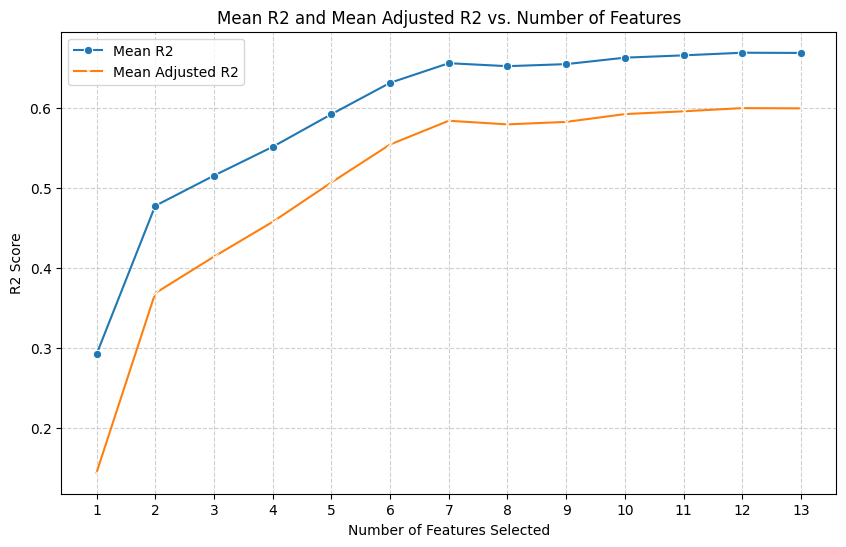

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(x='Num Features', y='Mean R2', data=results, marker='o', label='Mean R2')
sns.lineplot(x='Num Features', y='Mean Adjusted R2', data=results, marker='x', label='Mean Adjusted R2')

plt.title('Mean R2 and Mean Adjusted R2 vs. Number of Features')
plt.xlabel('Number of Features Selected')
plt.ylabel('R2 Score')
plt.xticks(results['Num Features'])
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

Let's look at the exact values:

**For 12 features:**

- Mean RMSE: -1,017,659.34 (best among all options, as it's the least negative)
- Mean R2: 0.658
- Mean Adjusted R2: 0.588

**For 13 features:**

- Mean RMSE: -1,018,041.30
- Mean R2: 0.657
- Mean Adjusted R2: 0.584

The GridSearchCV selected 12 features because its Mean RMSE score is slightly better (less negative) than that of 13 features. This indicates a marginally lower prediction error. The Adjusted R2 also slightly favors 12 features, as it penalizes for the additional complexity of an extra feature without a significant gain in explanatory power.

In [119]:
# 1. Pull out the winner
final_model = grid.best_estimator_

# 2. Predict on the TEST set
y_test_pred = final_model.predict(X_test)

# 3. See how we did
print(f"Final Test R2 Score: {r2_score(y_test, y_test_pred):.3f}")

Final Test R2 Score: 0.648


In [120]:
# Save model
import joblib

# Save the entire pipeline (Scaler + RFE + Model) into one file
# joblib.dump(final_model, 'best_housing_model.pkl')

print("Success! Your model is saved and ready for production.")

Success! Your model is saved and ready for production.
